# Krotov and Hopfield's model

In [95]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm.notebook import tqdm_notebook as tqdm

# custom imports
from context import LocalLearning

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from torchvision import datasets, transforms

In [96]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [97]:
pSet = LocalLearning.LocalLearningModel.pSet
pSet["in_size"] = 32**2 * 3 # CIFAR10 consists of 32x32 pixel 3 channel coloured images
pSet["tau_l"] = 1.0 / 0.02 # learning rate 0.04 leads to nans in model.W
pSet["Delta"] = 0.4
pSet["p"] = 2.0
pSet["k"] = 2
pSet["hidden_size"]=2500

## Parameters and Definitions

In [6]:
num_pixel = 32**2*3
#num_test = x_test.shape[0]
#x_train_flat = x_train.reshape(num_train, num_pixel)
eps0 = 2e-2    # learning rate
Kx = 50
Ky = 50
num_hidden = Kx * Ky    # number of hidden units that are displayed in Ky by Kx array
mu = 0.0
sigma = 1.0
num_epochs = 1000    # number of epochs
num_batch = 1000      # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

In [7]:
def synaptic_activation(synapses, inputs):
    return (synapses.sign() * synapses.abs() ** (p - 1)).matmul(inputs)

def learning_activation(indices):
    best_ind, best_k_ind = indices[0], indices[k-1]
    g_i = torch.zeros(num_hidden, num_batch).to(device)
    g_i[best_ind,   torch.arange(num_batch).to(device)] = 1.0
    g_i[best_k_ind, torch.arange(num_batch).to(device)] = -delta
    return g_i

## Renormalized Dataset

In [8]:
training_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10", train=True, transform=ToTensor(), p=pSet["p"]
)

dataloader_train = DataLoader(
    training_data, batch_size=num_batch, num_workers=10, shuffle=True
)

num_train = len(training_data)

Files already downloaded and verified


## Training the synapses

In [20]:
with tqdm(range(num_epochs), unit="epochs") as tepoch:
    for epoch in tepoch:
        for j in range(100):
            pass

  0%|          | 0/1000 [00:00<?, ?epochs/s]

In [22]:
synapses = torch.Tensor(num_hidden, num_pixel).normal_(mu, sigma).to(device)
flatten = torch.nn.Flatten()

with tqdm(range(num_epochs), unit="epochs") as tepoch:
    for epoch in tepoch:
        # decay learning rate
        eps = eps0 * (1 - epoch / num_epochs)
        # shuffle data
        #x_train_flat = x_train_flat[torch.randperm(x_train_flat.size(0))]
        
        for features, labels in dataloader_train:
            
            inputs = flatten(features.to(device)).t()
            # I = <W,v> synaptic activation
            tot_input = synaptic_activation(synapses, inputs)
            
            # find indices maximizing the synapse
            _, indices = tot_input.topk(k, dim=0)
            # g(Q) learning activation function
            g_i = learning_activation(indices)
            # Learning algorithm
            xx = (g_i * tot_input).sum(dim=1)
            ds = torch.matmul(g_i, inputs.t()) - xx.unsqueeze(1) * synapses
            
            nc = max(ds.abs().max(), prec)
            
            # the actual update
            synapses += eps * ds / nc 
            ###################

  0%|          | 0/1000 [00:00<?, ?epochs/s]

In [23]:
torch.save(synapses, "./krotov_hopfield_synapses.pth")

## Statistics

In [98]:
from torch import Tensor

def stringer_spectrum(nu):
    return 1 / nu

def cov_spectrum(
    dataloader: DataLoader, model, device: torch.device
) -> Tensor:
    """
    Calculate the ordered spectrum of the covariance matrix
    """
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as ttest:

            #noE = model.pSet["hidden_size"]
            noE = pSet["hidden_size"]

            """
            Calculate covariance matrix on shifted data to increase
            computational stability
            """

            # initialize stat tensors
            corr = torch.zeros((noE, noE), device=device)
            mean = torch.zeros((noE,), device=device)
            pop_size = 0

            ttest.set_description(f"Calculating covariance spectrum")

            # shift = estimate of the mean
            f, label = next(iter(dataloader))
            K = f.mean()

            for x, label in ttest:
                pop_size += len(x)
                pred = model(x.to(device))
                corr += (pred - K) @ (pred.T - K)
                mean += pred.sum(axis=-1) - K

            cov = corr - mean.T @ mean / pop_size
            cov /= pop_size - 1

            l_real = torch.linalg.eigvals(cov).real
            l_sorted, idx = torch.sort(l_real, descending=True)
            return l_sorted

In [99]:
testing_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10", train=False, transform=ToTensor(), p=pSet["p"]
)

dataloader_test = DataLoader(
    testing_data, batch_size=num_batch, num_workers=10, shuffle=False
)

Files already downloaded and verified


In [100]:
synapses_inf = torch.load("./krotov_hopfield_synapses.pth")

In [101]:
llmodel = lambda x: synaptic_activation(synapses_inf, flatten(x).T)
l_synapses = cov_spectrum(dataloader_test, llmodel, device=device)

  0%|          | 0/10 [00:00<?, ?batch/s]

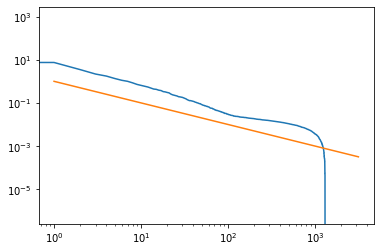

In [77]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.loglog(l_synapses.cpu().detach().numpy())
n = np.logspace(-1e-8, 3.5, num=100, base=10.0)
ax.loglog(n, stringer_spectrum(n))

## Scikit learn analysis

In [13]:
from sklearn.decomposition import PCA

testing_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10", train=False, transform=ToTensor(), p=pSet["p"]
)

dataloader_test = DataLoader(
    testing_data, batch_size=10000, num_workers=10, shuffle=False
)

synapses_inf = torch.load("./krotov_hopfield_synapses.pth")

Files already downloaded and verified


In [14]:
features_test, _ = next(iter(dataloader_test))

In [16]:
flatten = torch.nn.Flatten()
activations = synaptic_activation(synapses_inf, flatten(features_test.to(device)).T)

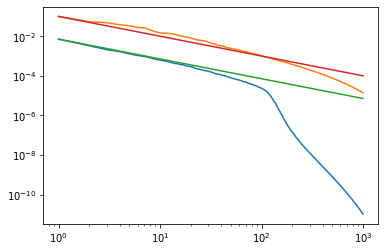

In [60]:
pca_activation = PCA()
pca_features = PCA()
pca_activation.fit(activations.cpu().numpy())
pca_features.fit(flatten(features_test).cpu().numpy())
n = 1000
plt.figure()
plt.loglog(np.arange(1, n), pca_activation.explained_variance_ratio_[1:n])
plt.loglog(np.arange(1, n), pca_features.explained_variance_ratio_[1:n])
# first principal component
first_pca_activation = pca_activation.explained_variance_ratio_[1]
plt.loglog(np.arange(1, n), first_pca_activation / np.arange(1, n))

first_pca_features = pca_features.explained_variance_ratio_[1]
plt.loglog(np.arange(1, n), first_pca_features / np.arange(1, n))

In [61]:
print(pca_activation.explained_variance_ratio_.shape)
#print(first_pca_activation)

(2500,)


In [29]:
import powerlaw

In [33]:
results_activation = powerlaw.Fit(pca_activation.explained_variance_ratio_[:100])
print(results_activation.power_law.alpha)
print(results_activation.power_law.xmin)

1.7412326215448264
9.161050547845662e-05


Calculating best minimal value for power law fit


In [34]:
results_features = powerlaw.Fit(pca_features.explained_variance_ratio_)
print(results_features.power_law.alpha)
print(results_features.power_law.xmin)

Calculating best minimal value for power law fit


1.7564061464788574
0.00040612524026073515


## Plot the shit out of it

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


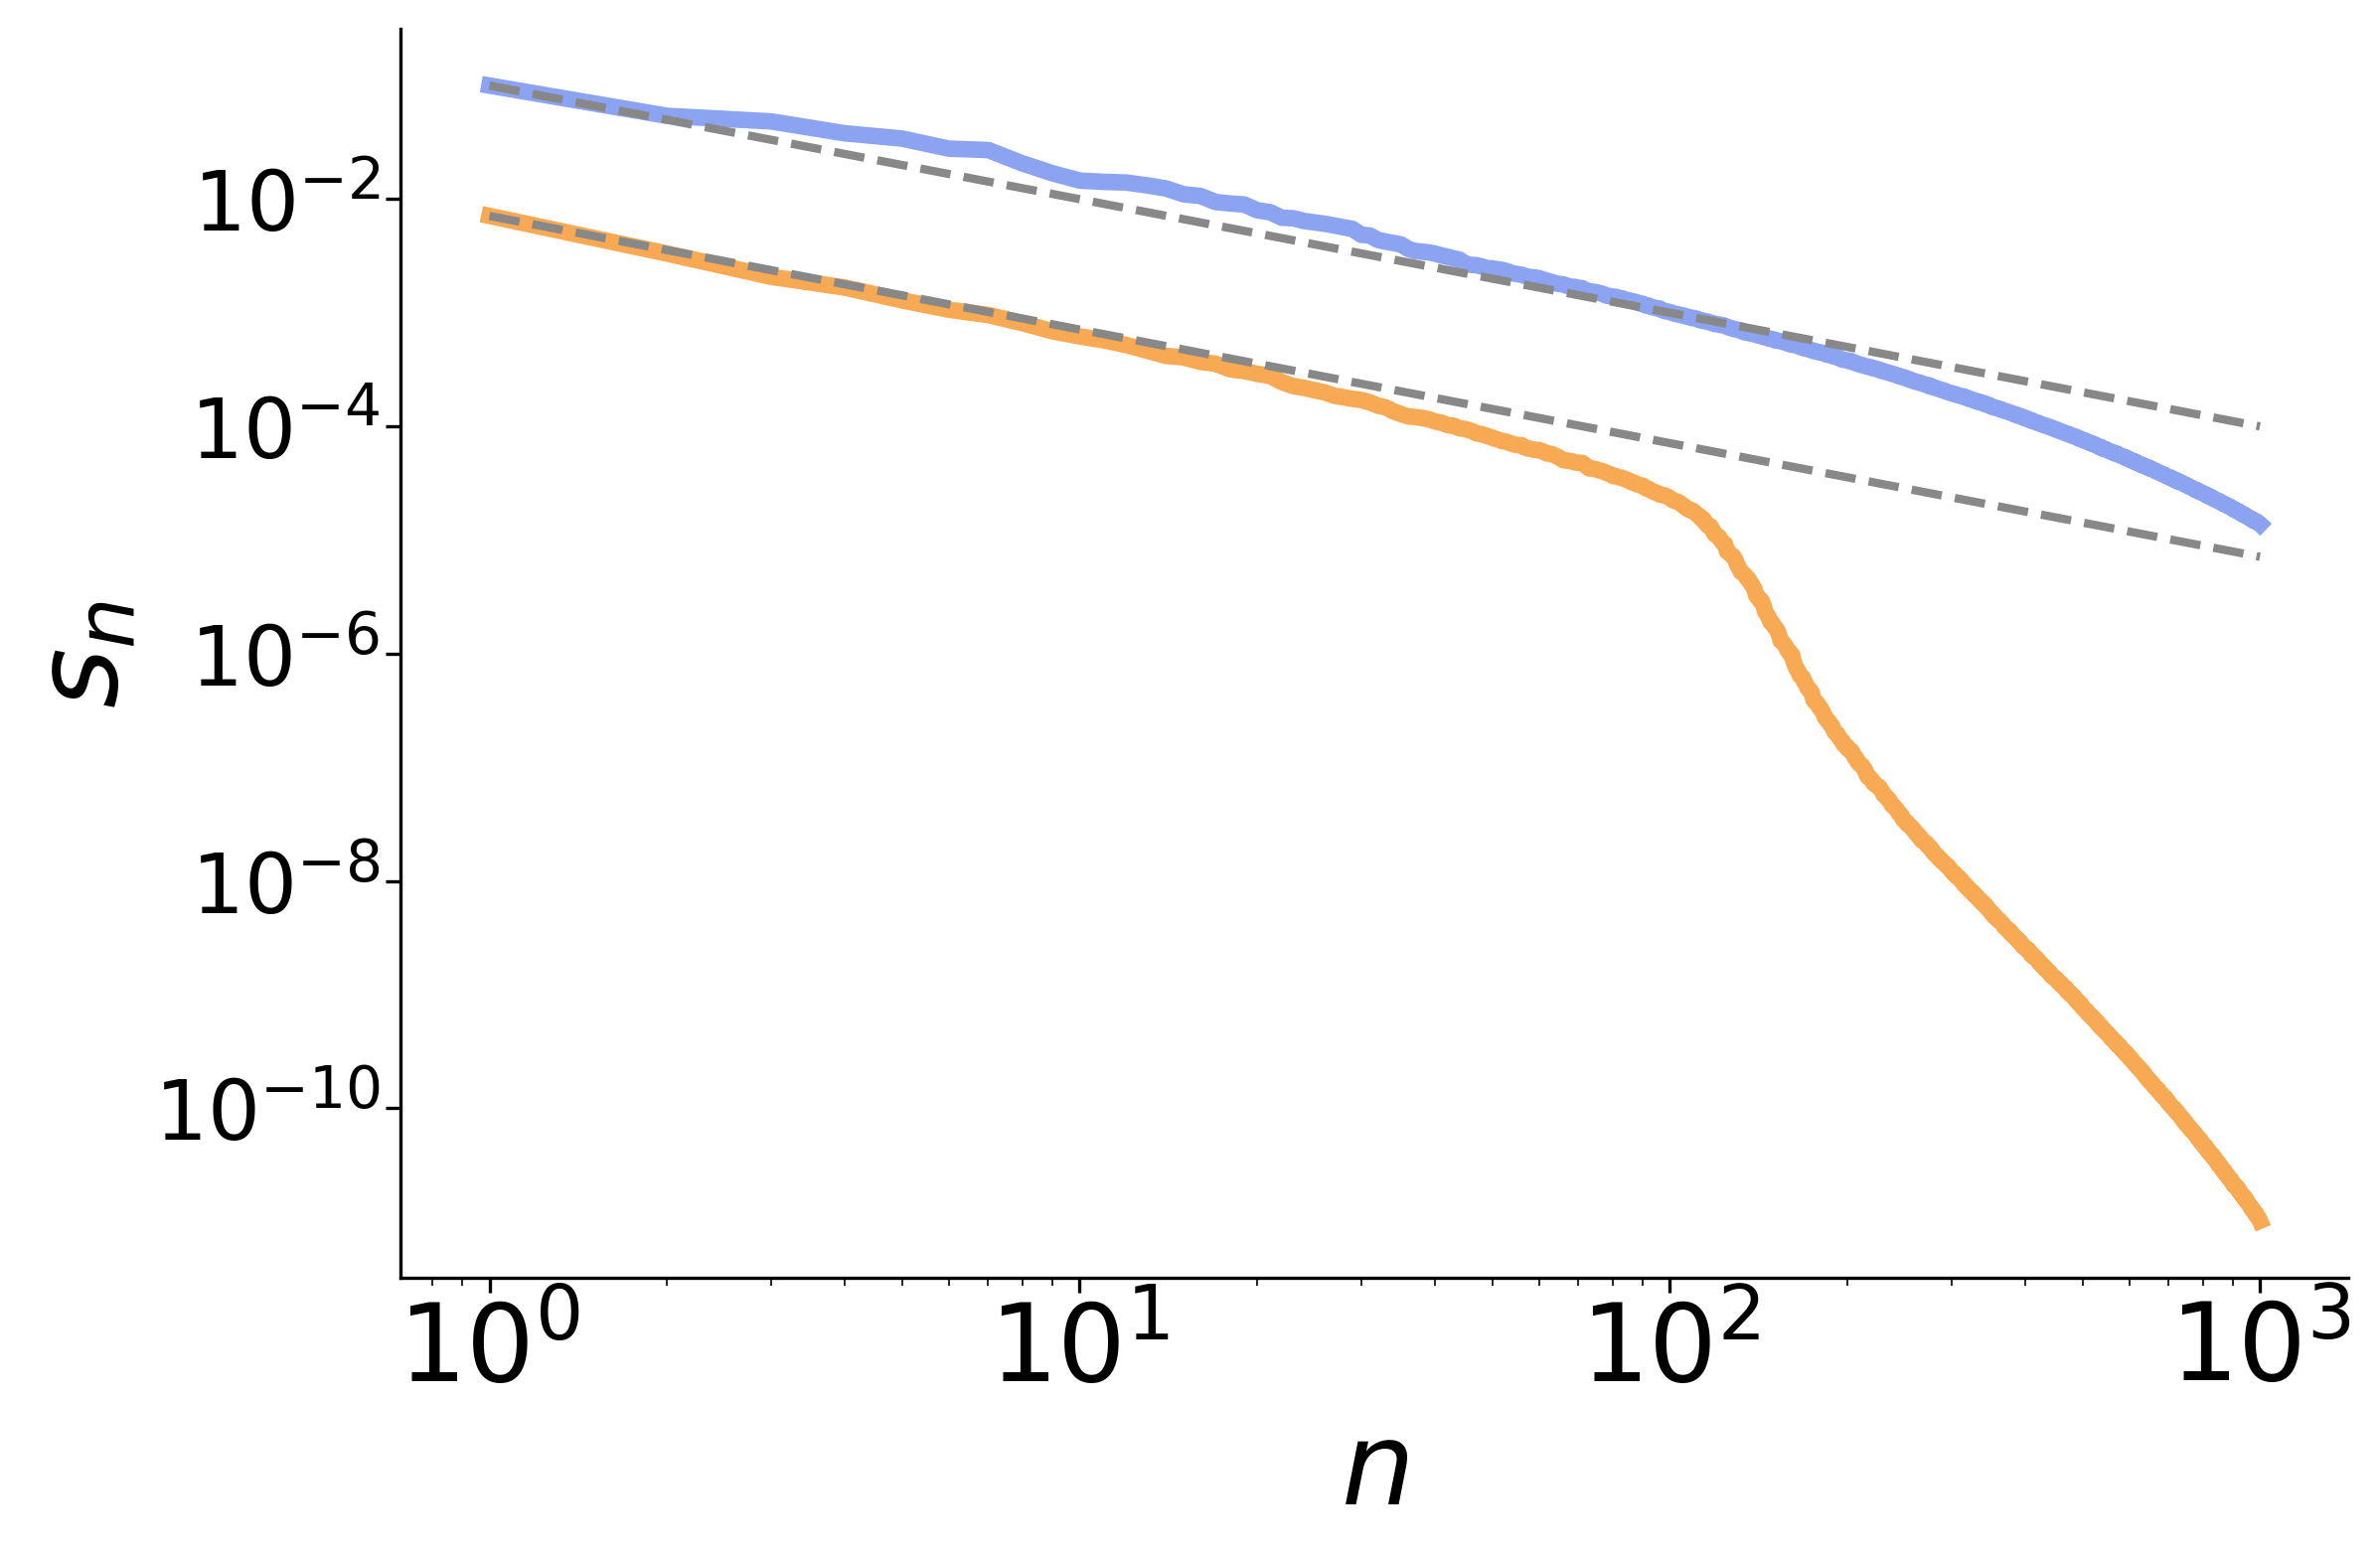

In [93]:
plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])
n=1000
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(7.87, 5.11)
ax = fig.add_subplot()
ax.loglog(np.arange(1, n), pca_activation.explained_variance_ratio_[1:n], color='#f8a953', linewidth=4.0, linestyle='solid')
ax.loglog(np.arange(1, n), pca_features.explained_variance_ratio_[1:n], color='#8ca3f1', linewidth=4.0, linestyle='solid')
# first principal component
first_pca_activation = pca_activation.explained_variance_ratio_[1]
ax.loglog(np.arange(1, n), first_pca_activation / np.arange(1, n), color='#888888', linewidth=2.0, linestyle='dashed')

first_pca_features = pca_features.explained_variance_ratio_[1]
ax.loglog(np.arange(1, n), first_pca_features / np.arange(1, n), color='#888888', linewidth=2.0, linestyle='dashed')

ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$s_{n}$")

fig.savefig("./PCA_spectrum_large.svg")

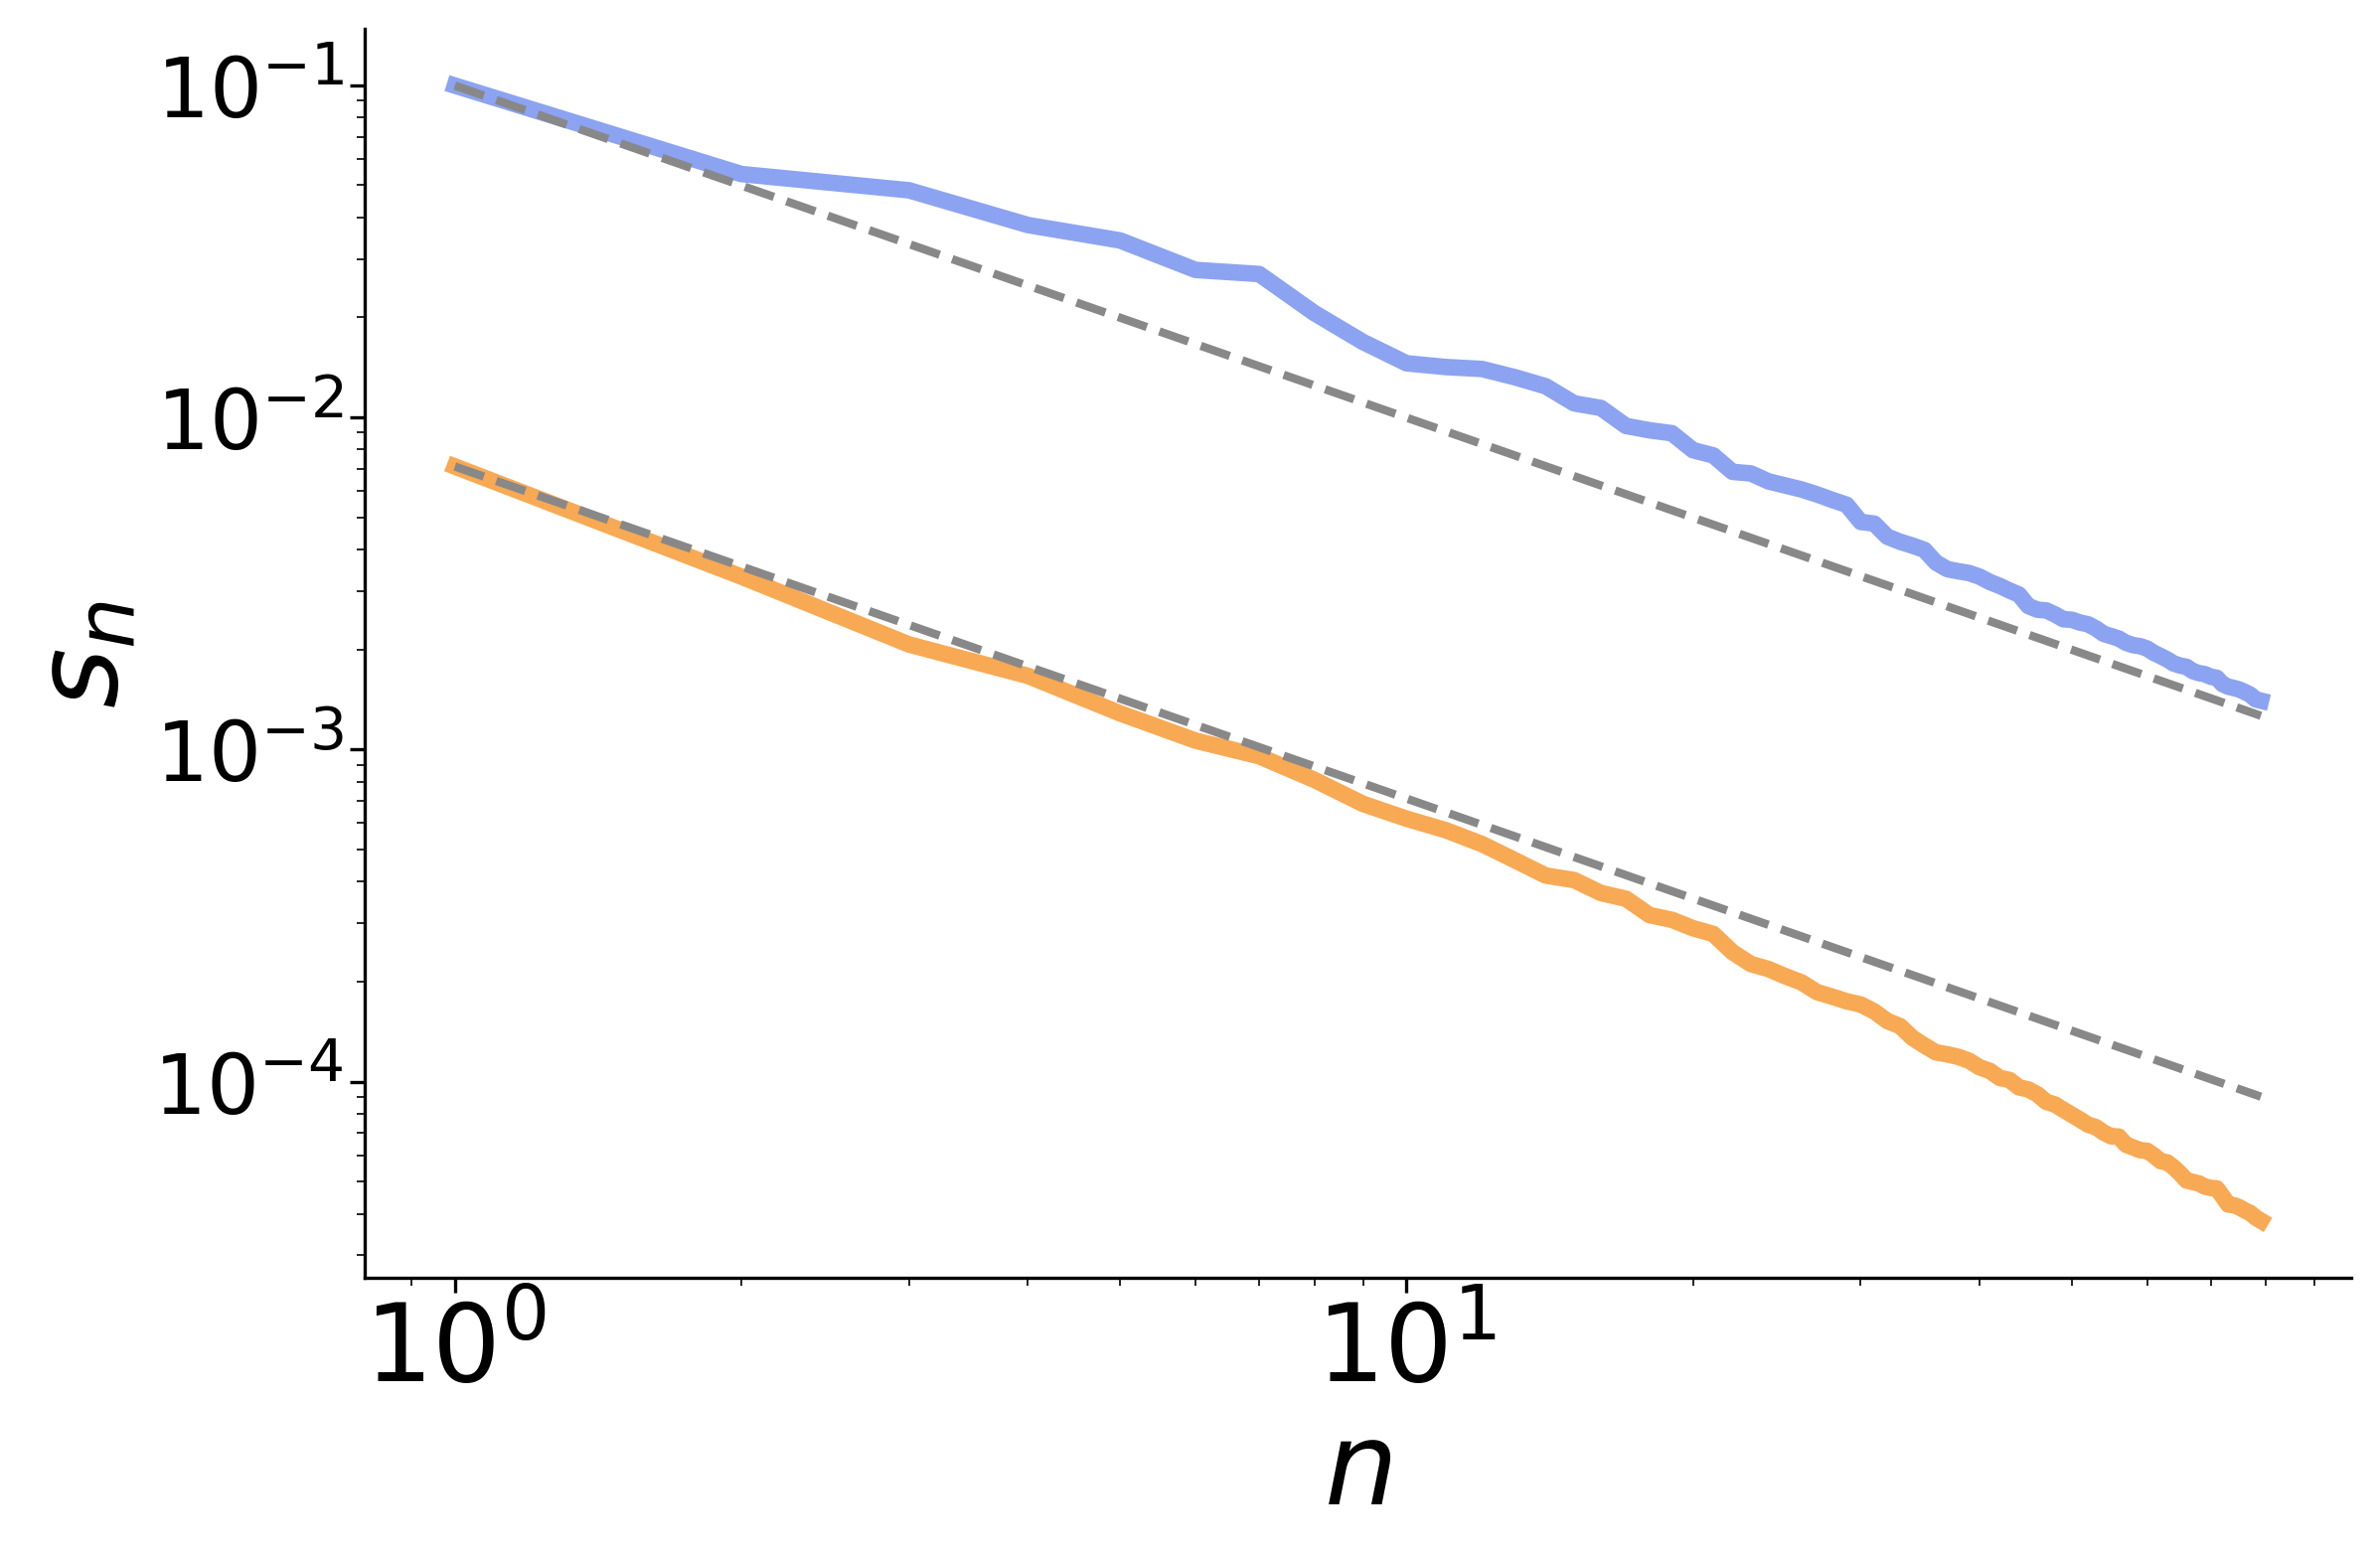

In [94]:
plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])
n=80
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(7.87, 5.11)
ax = fig.add_subplot()
ax.loglog(np.arange(1, n), pca_activation.explained_variance_ratio_[1:n], color='#f8a953', linewidth=4.0, linestyle='solid')
ax.loglog(np.arange(1, n), pca_features.explained_variance_ratio_[1:n], color='#8ca3f1', linewidth=4.0, linestyle='solid')
# first principal component
first_pca_activation = pca_activation.explained_variance_ratio_[1]
ax.loglog(np.arange(1, n), first_pca_activation / np.arange(1, n), color='#888888', linewidth=2.0, linestyle='dashed')

first_pca_features = pca_features.explained_variance_ratio_[1]
ax.loglog(np.arange(1, n), first_pca_features / np.arange(1, n), color='#888888', linewidth=2.0, linestyle='dashed')

ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$s_{n}$")

fig.savefig("./PCA_spectrum_closeup.svg")